In [13]:
from utils import *
from models import *
from loss import *
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime

In [14]:
train_path = '../next_day_fires/next_day_wildfire_spread_train*'
val_path = '../next_day_fires/next_day_wildfire_spread_eval*'
test_path = '../next_day_fires/next_day_wildfire_spread_test*'
features = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask', 'FireMask']

# Load Data

## Training Data

In [15]:
train_dataset = get_dataset(
      train_path,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

train_inputs, train_labels = next(iter(train_dataset))

print(train_inputs.shape)
print(train_labels.shape)

torch.Size([100, 12, 32, 32])
torch.Size([100, 1, 32, 32])


In [16]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

n_rows = 5
n_features = train_inputs.shape[3] 
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
keys = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

In [17]:
# fig = plt.figure(figsize=(20,8))

# for i in range(n_rows):
#   for j in range(n_features + 1):
#     plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
#     if i == 0:
#       plt.title(titles[j], fontsize=15)
#     if j < n_features - 1:
#       plt.imshow(train_inputs[i, j, :, :], cmap='viridis')
#     if j == n_features - 1:
#       plt.imshow(train_inputs[i, -1, :, :], cmap=CMAP, norm=NORM)
#     if j == n_features:
#       plt.imshow(train_labels[i, 0, :, :], cmap=CMAP, norm=NORM) 
#     plt.axis('off')
# plt.tight_layout()

## Vlidation Data

In [18]:
val_dataset = get_dataset(
      val_path,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

val_inputs, val_labels = next(iter(val_dataset))

print(val_inputs.shape)
print(val_labels.shape)

torch.Size([100, 12, 32, 32])
torch.Size([100, 1, 32, 32])


## Test Data

In [19]:
test_dataset = get_dataset(
      test_path,
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test_inputs, test_labels = next(iter(val_dataset))

print(test_inputs.shape)
print(test_labels.shape)

torch.Size([100, 12, 32, 32])
torch.Size([100, 1, 32, 32])


In [20]:
# Build DataLoader
train_loader = DataLoader(train_dataset, batch_size=None, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=None, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=None, num_workers=0, pin_memory=True)

# Model Initialization

In [21]:
folder_path = './diff_models'
gen_input_channels = 12
disc_input_channels = 13
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
device

device(type='cuda')

### Hyperparameters

### Model Initialization

# Model Training

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SinusoidalPosEmb(nn.Module):
    """Sinusoidal positional embedding for time steps."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        
    def forward(self, t):
        # t: [batch] of timesteps (float or long)
        device = t.device
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = t[:, None].float() * emb[None, :]  # [batch, half_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        if self.dim % 2 == 1:  # if odd dimensionality
            emb = F.pad(emb, (0, 1, 0, 0))
        return emb  # [batch, dim]

class ResidualBlock(nn.Module):
    """Residual block with optional time embedding."""
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.norm1 = nn.GroupNorm(num_groups=8, num_channels=in_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups=8, num_channels=out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.time_proj = nn.Linear(time_emb_dim, out_channels)
        if in_channels != out_channels:
            self.skip_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.skip_conv = None
    
    def forward(self, x, t_emb):
        h = self.norm1(x)
        h = F.relu(h)
        h = self.conv1(h)
        # Add time embedding
        if t_emb is not None:
            time_emb = self.time_proj(F.relu(t_emb))
            h = h + time_emb[:, :, None, None]
        h = self.norm2(h)
        h = F.relu(h)
        h = self.conv2(h)
        # Skip connection
        if self.skip_conv is not None:
            x = self.skip_conv(x)
        return x + h

class SelfAttention(nn.Module):
    """Multi-head self-attention layer."""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.attn = nn.MultiheadAttention(embed_dim=channels, num_heads=num_heads)
        self.proj_out = nn.Conv2d(channels, channels, kernel_size=1)
    
    def forward(self, x):
        B, C, H, W = x.shape
        h = self.norm(x).view(B, C, H * W).permute(2, 0, 1)  # [HW, B, C]
        attn_out, _ = self.attn(h, h, h)
        attn_out = attn_out.permute(1, 2, 0).contiguous().view(B, C, H, W)
        attn_out = self.proj_out(attn_out)
        return x + attn_out

class Down(nn.Module):
    """Downsampling block: 2 ResBlocks + Conv2d downsample."""
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.res1 = ResidualBlock(in_channels, out_channels, time_emb_dim)
        self.res2 = ResidualBlock(out_channels, out_channels, time_emb_dim)
        self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)
    
    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.res2(x, t)
        x_down = self.downsample(x)
        return x_down, x  # return downsampled output and skip connection

class Up(nn.Module):
    """Upsampling block: ConvTranspose2d upsample + 2 ResBlocks."""
    def __init__(self, in_channels, skip_channels, out_channels, time_emb_dim):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1)
        self.res1 = ResidualBlock(out_channels + skip_channels, out_channels, time_emb_dim)
        self.res2 = ResidualBlock(out_channels, out_channels, time_emb_dim)
    
    def forward(self, x, skip, t):
        x = self.upsample(x)                # Upsample
        x = torch.cat([x, skip], dim=1)    # Concatenate skip connection
        x = self.res1(x, t)
        x = self.res2(x, t)
        return x

class UNet(nn.Module):
    """U-Net model for conditional diffusion (13->1 channels)."""
    def __init__(self, in_channels=13, base_channels=64, channel_mults=(1,2,4,8), time_emb_dim=256):
        super().__init__()
        # Time embedding
        self.time_emb = SinusoidalPosEmb(time_emb_dim // 2)
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim // 2, time_emb_dim), nn.ReLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        # Initial convolution
        self.init_conv = nn.Conv2d(in_channels, base_channels * channel_mults[0], kernel_size=3, padding=1)
        # Downsample blocks
        self.down1 = Down(base_channels * channel_mults[0], base_channels * channel_mults[1], time_emb_dim)
        self.down2 = Down(base_channels * channel_mults[1], base_channels * channel_mults[2], time_emb_dim)
        self.attn_down2 = SelfAttention(base_channels * channel_mults[2])
        self.down3 = Down(base_channels * channel_mults[2], base_channels * channel_mults[3], time_emb_dim)
        # Bottleneck
        self.mid_res1 = ResidualBlock(base_channels * channel_mults[3], base_channels * channel_mults[3], time_emb_dim)
        self.mid_attn = SelfAttention(base_channels * channel_mults[3])
        self.mid_res2 = ResidualBlock(base_channels * channel_mults[3], base_channels * channel_mults[3], time_emb_dim)
        # Upsample blocks
        self.up3 = Up(base_channels * channel_mults[3], base_channels * channel_mults[3], base_channels * channel_mults[2], time_emb_dim)
        self.up2 = Up(base_channels * channel_mults[2], base_channels * channel_mults[2], base_channels * channel_mults[1], time_emb_dim)
        self.up1 = Up(base_channels * channel_mults[1], base_channels * channel_mults[1], base_channels * channel_mults[0], time_emb_dim)
        # Final conv to one channel output
        self.final_conv = nn.Sequential(
            nn.GroupNorm(num_groups=8, num_channels=base_channels * channel_mults[0]),
            nn.ReLU(),
            nn.Conv2d(base_channels * channel_mults[0], 1, kernel_size=1)
        )
    
    def forward(self, x, t):
        # x: [B,13,32,32], t: [B] timesteps
        t_emb = self.time_emb(t)          # [B, time_emb_dim//2]
        t_emb = self.time_mlp(t_emb)      # [B, time_emb_dim]
        x = self.init_conv(x)            # [B, base, 32,32]
        x1, skip1 = self.down1(x, t_emb)   # [B, C1, 16,16], skip1 [B, C1,16,16]
        x2, skip2 = self.down2(x1, t_emb)  # [B, C2, 8,8], skip2 [B, C2,8,8]
        x2 = self.attn_down2(x2)          # Self-attention at 8x8
        x3, skip3 = self.down3(x2, t_emb)  # [B, C3, 4,4], skip3 [B, C3,4,4]
        x_mid = self.mid_res1(x3, t_emb)
        x_mid = self.mid_attn(x_mid)       # Self-attention at 4x4
        x_mid = self.mid_res2(x_mid, t_emb)
        x = self.up3(x_mid, skip3, t_emb)  # [B, C2, 8,8]
        x = self.up2(x, skip2, t_emb)      # [B, C1, 16,16]
        x = self.up1(x, skip1, t_emb)      # [B, base, 32,32]
        x = self.final_conv(x)            # [B, 1, 32,32]
        return x


In [25]:
import torch
import torch.nn.functional as F

class Diffusion:
    """Diffusion process with linear beta schedule."""
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        self.timesteps = timesteps
        self.device = device
        betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.betas = betas
        self.alphas = 1.0 - betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)             # \bar{alpha}_t
        self.sqrt_alpha_hat = torch.sqrt(self.alpha_hat)               # sqrt(\bar{alpha}_t)
        self.sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat) # sqrt(1-\bar{alpha}_t)
    
    def q_sample(self, x_start, t):
        """Sample q(x_t | x_0): add noise to x_start for timestep t."""
        noise = torch.randn_like(x_start)
        # Expand scalars to batch dims
        sqrt_alpha_hat_t = self.sqrt_alpha_hat[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alpha_hat_t = self.sqrt_one_minus_alpha_hat[t].view(-1, 1, 1, 1)
        x_t = sqrt_alpha_hat_t * x_start + sqrt_one_minus_alpha_hat_t * noise
        return x_t, noise

    @torch.no_grad()
    def sample(self, model, cond, steps=None, guidance_scale=1.0):
        """Generate samples given conditional input using reverse diffusion."""
        if steps is None:
            steps = self.timesteps
        B = cond.shape[0]
        x = torch.randn((B, 1, cond.shape[2], cond.shape[3]), device=self.device)  # Start from noise
        for t in reversed(range(steps)):
            t_batch = torch.full((B,), t, dtype=torch.long, device=self.device)
            # Prepare inputs for conditional and unconditional (zeros) predictions
            x_in_cond = torch.cat([cond, x], dim=1)        # [B, 13, 32,32]
            x_in_uncond = torch.cat([torch.zeros_like(cond), x], dim=1)
            noise_cond = model(x_in_cond, t_batch)         # Predicted noise (conditional)
            noise_uncond = model(x_in_uncond, t_batch)     # Predicted noise (unconditional)
            # Classifier-free guidance
            noise_pred = noise_uncond + guidance_scale * (noise_cond - noise_uncond)
            # Compute x0 estimate
            alpha_hat_t = self.alpha_hat[t]
            sqrt_alpha_hat_t = self.sqrt_alpha_hat[t]
            if t > 0:
                alpha_hat_prev = self.alpha_hat[t-1]
                sqrt_alpha_hat_prev = torch.sqrt(alpha_hat_prev)
            else:
                alpha_hat_prev = torch.tensor(1.0, device=self.device)
                sqrt_alpha_hat_prev = torch.tensor(1.0, device=self.device)
            x0_pred = (x - (self.sqrt_one_minus_alpha_hat[t] * noise_pred)) / sqrt_alpha_hat_t
            # Compute x_{t-1} (add noise except for final step)
            if t > 0:
                noise = torch.randn_like(x)
                x = sqrt_alpha_hat_prev * x0_pred + torch.sqrt(1 - alpha_hat_prev) * noise
            else:
                x = x0_pred
        return x  # [B,1,32,32]

def train_with_early_stopping(
    model,
    diffusion,
    train_loader,
    val_loader,
    lr=1e-4,
    num_epochs=200,
    patience=50,
    folder_path='./checkpoints',
    device='cpu'
):
    os.makedirs(folder_path, exist_ok=True)
    
    # Optimizer & tracking
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None
    best_model_path = None

    model.to(device)

    for epoch in range(1, num_epochs + 1):
        # ---------- Train ----------
        model.train()
        train_loss_sum = 0.0
        for features, target in train_loader:
            features = features.to(device)        # [B,12,32,32]
            target   = target.to(device)         # [B,1,32,32]
            B = features.size(0)

            # 1) 랜덤 timestep 선택, noisy sample 생성
            t = torch.randint(0, diffusion.timesteps, (B,), device=device)
            x_noisy, noise = diffusion.q_sample(target, t)

            # 2) 모델 입력: [B, 13, 32,32]
            inp = torch.cat([features, x_noisy], dim=1)
            pred_noise = model(inp, t)

            # 3) 손실 계산 및 역전파
            loss = F.mse_loss(pred_noise, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_sum += loss.item()

        train_avg_loss = train_loss_sum / len(train_loader)

        # ---------- Validation ----------
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for features, target in val_loader:
                features = features.to(device)
                target   = target.to(device)
                B = features.size(0)

                t = torch.randint(0, diffusion.timesteps, (B,), device=device)
                x_noisy, noise = diffusion.q_sample(target, t)
                inp = torch.cat([features, x_noisy], dim=1)
                pred_noise = model(inp, t)
                loss = F.mse_loss(pred_noise, noise)
                val_loss_sum += loss.item()

        val_avg_loss = val_loss_sum / len(val_loader)

        # ---------- Logging ----------
        print(f"Epoch {epoch}/{num_epochs}")
        print(f"  Train Loss: {train_avg_loss:.4f} | Val Loss: {val_avg_loss:.4f}")

        # ---------- Early Stopping & Checkpoint ----------
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            best_model_path = os.path.join(
                folder_path,
                f"best_diffusion_{best_val_loss:.4f}_{timestamp}.pth"
            )
            
            print(f"  ▶️ Validation improved. ")
        else:
            epochs_no_improve += 1
            print(f"  No improvement for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"⏹️ Early stopping triggered (patience={patience}).")
            break

    print("Training finished.")
    return best_model_path, best_model_state


# Example usage (assuming .npy dataset files exist):
# dataset = WildfireDataset('features.npy', 'targets.npy')
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
diffusion = Diffusion(timesteps=1000, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
path, state = train_with_early_stopping(model, diffusion, train_loader, val_loader, device=device)
#
# # Sampling example after training:
#model.eval()
# sample_cond = torch.randn(1, 12, 32, 32).to(device)  # example condition
# generated = diffusion.sample(model, sample_cond, steps=1000, guidance_scale=2.0)
# # 'generated' is a [1,1,32,32] predicted wildfire spread map.


Epoch 1/200
  Train Loss: 1.0006 | Val Loss: 1.0010
  ▶️ Validation improved. 
Epoch 2/200
  Train Loss: 1.0003 | Val Loss: 1.0006
  ▶️ Validation improved. 
Epoch 3/200
  Train Loss: 1.0005 | Val Loss: 0.9980
  ▶️ Validation improved. 
Epoch 4/200
  Train Loss: 1.0001 | Val Loss: 0.9999
  No improvement for 1 epoch(s).
Epoch 5/200
  Train Loss: 0.9996 | Val Loss: 0.9982
  No improvement for 2 epoch(s).
Epoch 6/200
  Train Loss: 0.9992 | Val Loss: 0.9980
  No improvement for 3 epoch(s).
Epoch 7/200
  Train Loss: 0.9959 | Val Loss: 0.9734
  ▶️ Validation improved. 
Epoch 8/200
  Train Loss: 0.8043 | Val Loss: 0.5846
  ▶️ Validation improved. 
Epoch 9/200
  Train Loss: 0.4268 | Val Loss: 0.3207
  ▶️ Validation improved. 
Epoch 10/200
  Train Loss: 0.2869 | Val Loss: 0.3620
  No improvement for 1 epoch(s).
Epoch 11/200
  Train Loss: 0.2286 | Val Loss: 0.1886
  ▶️ Validation improved. 
Epoch 12/200
  Train Loss: 0.1668 | Val Loss: 0.1443
  ▶️ Validation improved. 
Epoch 13/200
  Train Loss

In [26]:
# save the best model
os.makedirs('./diff_models/models', exist_ok=True)
if state is not None:
    torch.save(state, path)
    print(f"Best model saved to {path}")

Best model saved to ./checkpoints\best_diffusion_0.0127_20250428_040350.pth


# Model Testing

In [29]:
import torch
import numpy as np

def evaluate_diffusion_model(
    model,
    diffusion,
    test_loader,
    checkpoint_path,
    device='cpu',
    guidance_scale=1.0,
    sample_steps=1000,
    bin_thresh=0.5
):
    """
    - model: UNet diffusion 모델
    - diffusion: Diffusion 인스턴스
    - test_loader: DataLoader for test set
    - checkpoint_path: best .pth 경로
    - guidance_scale, sample_steps: reverse diffusion 파라미터
    - bin_thresh: 이진화 임계값
    """
    # 1) 모델 로드 & 평가 모드
    state_dict = torch.load(checkpoint_path, map_location=device, weights_only=True)
    model.load_state_dict(state_dict)
    model.to(device).eval()

    preds_all = []
    trues_all = []

    with torch.no_grad():
        for features, target in test_loader:
            features = features.to(device)   # [B,12,32,32]
            target   = target.to(device)     # [B,1,32,32]

            # 2) reverse diffusion으로 예측 맵 생성
            generated = diffusion.sample(
                model=model,
                cond=features,
                steps=sample_steps,
                guidance_scale=guidance_scale
            )  # [B,1,32,32]

            # 3) CPU로 가져와 numpy 변환
            preds_all.append(generated.detach().cpu().numpy())
            trues_all.append(target.detach().cpu().numpy())

    # 4) 배치 합치기
    preds = np.concatenate(preds_all, axis=0)  # [N,1,32,32]
    trues = np.concatenate(trues_all, axis=0)

    # 5) (N,1,32,32) → (N,32,32)
    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)

    # 6) 이진화
    preds_bin = (preds > bin_thresh).astype(np.uint8)
    trues_bin = trues.astype(np.uint8)

    # 7) 평탄화
    preds_flat = preds_bin.flatten()
    trues_flat = trues_bin.flatten()

    # 8) TP, FP, FN 계산
    tp = np.logical_and(preds_flat == 1, trues_flat == 1).sum()
    fp = np.logical_and(preds_flat == 1, trues_flat == 0).sum()
    fn = np.logical_and(preds_flat == 0, trues_flat == 1).sum()

    smooth = 1e-6
    dice   = (2 * tp + smooth) / (2 * tp + fp + fn + smooth)
    iou    = (tp + smooth) / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
    }

    # 9) 결과 출력
    print("\n** Test Results **")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics, preds, trues


metrics, preds, trues = evaluate_diffusion_model(
    model=model,
    diffusion=diffusion,
    test_loader=test_loader,
    checkpoint_path=path,
    device=device,
    guidance_scale=2.0,
    sample_steps=500,
    bin_thresh=0.5
    )



** Test Results **
Dice Coefficient: 0.0650
IoU: 0.0336
Recall: 0.0723


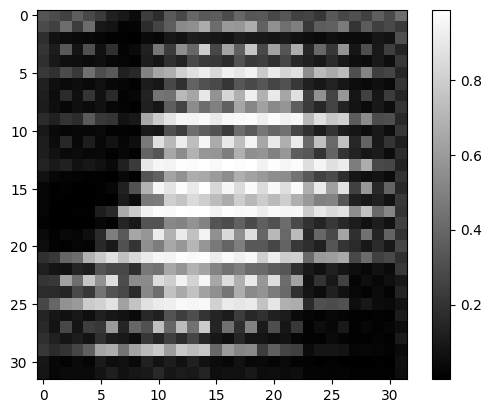

In [ ]:
img, lab = next(iter(test_loader))
pred = generator(img.to(device))
tensor_np = pred[2][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
lab[0][0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

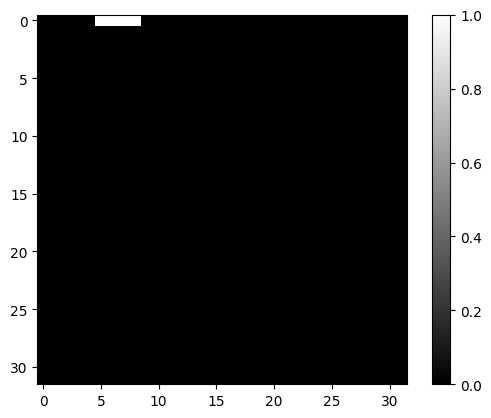

In [ ]:
tensor_np = lab[1][0].detach().cpu().numpy()

plt.imshow(tensor_np, cmap='gray')
plt.colorbar()
plt.show()